In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
print(tf.config.list_physical_devices('GPU'))

2023-09-26 21:45:31.044944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 21:45:31.155441: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras.optimizers import Adam

In [4]:
import footnet_parallel as ftnet

In [5]:
def split_df(_df):
    totalsize = _df.shape[0]
    trainsize, validsize = int(totalsize*0.85**2), int(totalsize*0.85*0.15)
    train_list  = _df[:trainsize]['path'].tolist()
    valid_list = _df[trainsize:(trainsize+validsize)]['path'].tolist()
    test_list = _df[(trainsize+validsize):]['path'].tolist()

    print(f"Train: {len(train_list)} \nVal: {len(valid_list)} \nTest: {len(test_list)}")
    return train_list, valid_list, test_list

combdf = pd.read_csv('../combined_data_set_Sept11_20k.csv')
train_list, valid_list, test_list = split_df(combdf[:])
print(len(train_list), len(valid_list), len(test_list))

Train: 14449 
Val: 2550 
Test: 3001
14449 2550 3001


In [6]:
model = ftnet.build_model(num_var=18)
opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss='mse')
model.load_weights('exp1/Unet_checkpt_0.59.h5')

2023-09-26 21:46:03.217607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 21:46:03.802289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13163 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [7]:
def permute_input(data, index, target):
    """
    input shape: (400, 400, 18)
    output shape: (400, 400, 18)
    """
    data_swap = data.copy()
    data_swap[:, :, [index, target]] = data_swap[:, :, [target, index]]
    return data_swap

# from skimage.metrics import structural_similarity as ssim
# from sklearn.metrics import mean_squared_error as mse

def IoU(truth, pred):
    intersec = np.logical_and(~np.isnan(truth), ~np.isnan(pred))
    union = np.logical_or(~np.isnan(truth), ~np.isnan(pred))
    return np.sum(intersec)/np.sum(union)

def performance_metrics(truth, pred):
    # _truth = truth.copy()
    # _truth[np.where(np.isnan(_truth))] = 0
    # _pred = pred.copy()
    # _pred[np.where(np.isnan(_pred))] = 0
    # # _ssim = ssim(_truth, _pred)  # _ssim, 
    # _rmse = mse(_truth, _pred, squared=False)
    pred_nonnan = pred[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]
    truth_nonnan = truth[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]
    _r2 = np.corrcoef(truth_nonnan, pred_nonnan)[0, 1]
    return _r2, IoU(truth, pred)

In [10]:
size = 1000
selected_samples = np.random.randint(0, len(test_list), size=size)
r2_drop = np.empty((size, 18))
IoU_drop = np.empty((size, 18))

curr = 0
for i in selected_samples:
    print(curr, size)
    data = np.load(test_list[i])
    xy = ftnet.transform_func_6h(data['pred'], data['_6hpred'], data['obs'])
    input_o, truth = xy[:, :, :-1], xy[:, :, -1]
    pred_o = model.predict(input_o[np.newaxis, :, :, :])
    truth[truth <= 0] = np.nan
    pred_o[pred_o <= 0] = np.nan

    for j in range(12):
        _r2_drop = []
        _IoU_drop = []
        other_index = list(range(12))
        other_index.remove(j)
        for jj in other_index:
            input_p = permute_input(input_o, j, jj)
            pred_p = model.predict(input_p[np.newaxis, :, :, :], verbose=0)
            pred_p[pred_p <= 0] = np.nan
            r2_1, IoU_1 = performance_metrics(truth, pred_p[0, :, :, 0])
            r2_2, IoU_2 = performance_metrics(truth, pred_o[0, :, :, 0]) 
            r2_change, IoU_change = r2_1 - r2_2, IoU_1 - IoU_2
            _r2_drop.append(r2_change)
            _IoU_drop.append(IoU_change)
        r2_drop[curr, j] = np.nanmean(_r2_drop)
        IoU_drop[curr, j] = np.nanmean(_IoU_drop)
    curr += 1

0 1000
1/1 [==============================] - 0s 23ms/step
1 1000
1/1 [==============================] - 0s 23ms/step
2 1000
1/1 [==============================] - 0s 23ms/step
3 1000
1/1 [==============================] - 0s 23ms/step
4 1000
1/1 [==============================] - 0s 23ms/step
5 1000
1/1 [==============================] - 0s 25ms/step
6 1000
1/1 [==============================] - 0s 24ms/step
7 1000
1/1 [==============================] - 0s 23ms/step
8 1000
1/1 [==============================] - 0s 23ms/step
9 1000
1/1 [==============================] - 0s 23ms/step
10 1000
1/1 [==============================] - 0s 24ms/step
11 1000
1/1 [==============================] - 0s 23ms/step
12 1000
1/1 [==============================] - 0s 24ms/step
13 1000
1/1 [==============================] - 0s 23ms/step
14 1000
1/1 [==============================] - 0s 23ms/step
15 1000
1/1 [==============================] - 0s 23ms/step
16 1000
1/1 [==============================] - 0s 

In [11]:
np.savez('performance_drop.npz', r2_drop=r2_drop, IoU_drop=IoU_drop, sample_index=selected_samples)

In [17]:
r2_drop = r2_drop[:, :12]
IoU_drop = IoU_drop[:, :12]

In [18]:
var_names = ['GPR', 'U10M', 'V10M', 'PBLH', 'PRSS', 'PRES'] \
           +['GPR_6h', 'U10M_6h', 'V10M_6h', 'PBLH_6h', 'PRSS_6h', 'PRES_6h']

mean_values = np.nanmean(abs(r2_drop), axis=1)

In [19]:
abs_importance = abs(np.mean(r2_drop, axis=0))
order = [list(abs_importance).index(x) for x in sorted(abs_importance)]

In [20]:
r2_drop.shape, IoU_drop.shape

((1000, 12), (1000, 12))

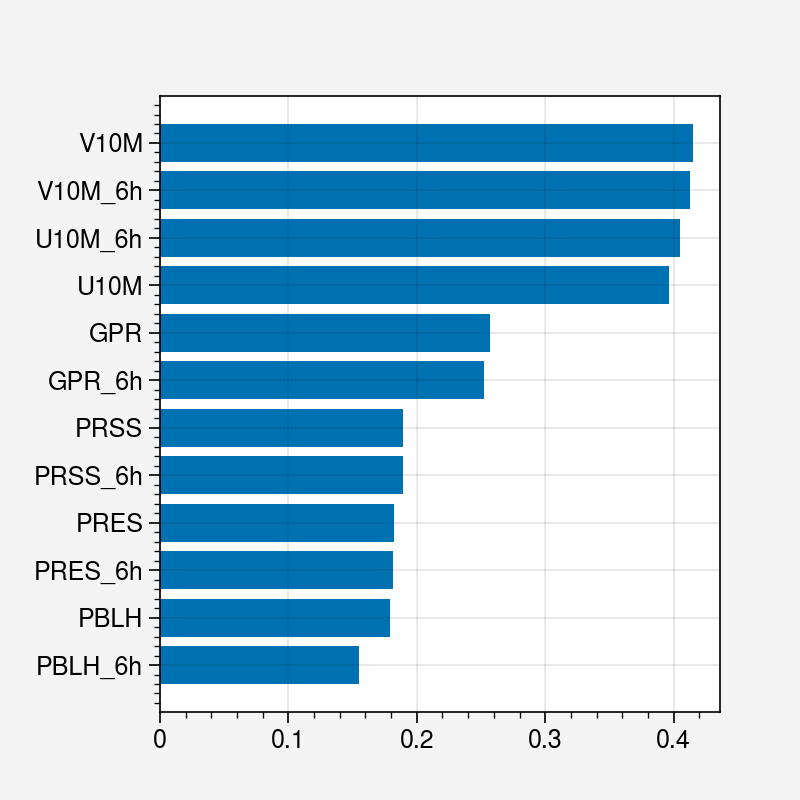

In [21]:
plt.barh(list(range(12)), sorted(abs_importance))
# plt.xlim((0, 0.71))
_ = plt.yticks(list(range(12)), np.array(var_names)[order])
plt.subplots_adjust(left=0.2)

In [22]:
import proplot as pplt

In [32]:
r2_drop_bygroup = r2_drop.reshape((1000, 2, 6))
r2_drop_variable = r2_drop_bygroup.reshape((-1, 6))
r2_drop_leadtime = np.moveaxis(r2_drop_bygroup, 2, 1)
r2_drop_leadtime = r2_drop_leadtime.reshape((-1, 2))
r2_drop_leadtime = abs(np.nanmean(r2_drop_leadtime, axis=0))
r2_drop_variable = abs(np.nanmean(r2_drop_variable, axis=0))

r2_drop_comb = np.concatenate([r2_drop_variable, r2_drop_leadtime])
r2_order = [list(r2_drop_comb).index(x) for x in sorted(r2_drop_comb)]
var_names = ['Gaussian plume', 'U10M', 'V10M', 'PBLH', 'PRSS', 'AD850'] \
           +['Met(t0)', 'Met(t0-6h)']

IoU_drop_bygroup = IoU_drop.reshape((1000, 2, 6))
IoU_drop_variable = IoU_drop_bygroup.reshape((-1, 6))
IoU_drop_leadtime = np.moveaxis(IoU_drop_bygroup, 2, 1)
IoU_drop_leadtime = IoU_drop_leadtime.reshape((-1, 2))
IoU_drop_leadtime = abs(np.nanmean(IoU_drop_leadtime, axis=0))
IoU_drop_variable = abs(np.nanmean(IoU_drop_variable, axis=0))

IoU_drop_comb = np.concatenate([IoU_drop_variable, IoU_drop_leadtime])
iou_order = [list(IoU_drop_comb).index(x) for x in sorted(IoU_drop_comb)]

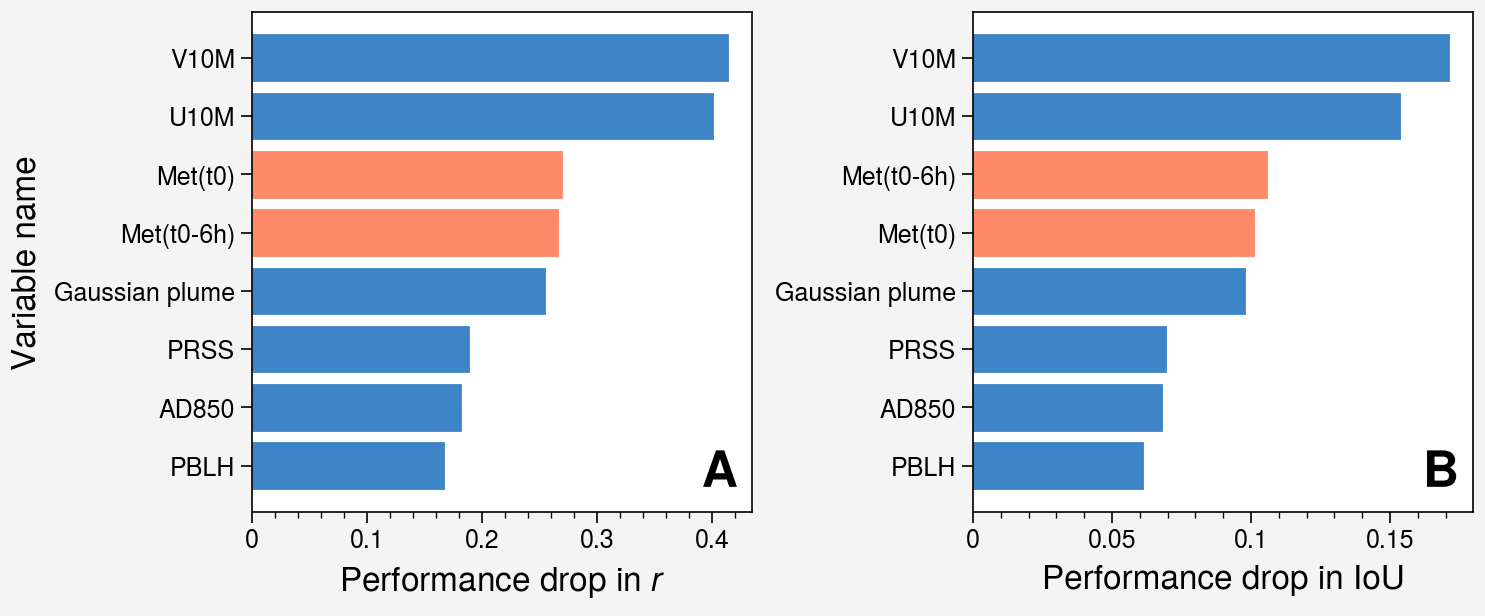

In [40]:
fig = pplt.figure(refwidth=2.5, share=False)
gs = pplt.GridSpec(ncols=2, nrows=1)
# plt.minorticks_off()

ax = fig.subplot(gs[0, 0])
ax.barh(list(range(8)), sorted(r2_drop_comb), color=['#3d85c6', '#3d85c6', '#3d85c6', '#3d85c6', '#ff8969', '#ff8969', '#3d85c6', '#3d85c6'])
ax.set_yticks(list(range(8)))
_ = ax.set_yticklabels(np.array(var_names)[r2_order])
ax.set_ylabel(ylabel='Variable name', fontsize=12)
ax.set_xlabel('Performance drop in $\it{r}$', fontsize=12)
ax.grid(False)

ax = fig.subplot(gs[0, 1])
ax.barh(list(range(8)), sorted(IoU_drop_comb), color=['#3d85c6', '#3d85c6', '#3d85c6', '#3d85c6', '#ff8969', '#ff8969', '#3d85c6', '#3d85c6'])
ax.set_yticks(list(range(8)))
_ = ax.set_yticklabels(np.array(var_names)[iou_order])
ax.set_xlabel('Performance drop in IoU', fontsize=12)
ax.grid(False)
fig.format(abc='A', abcloc='lr', abcbbox=False, abcsize=18, ytickminor=False)

plt.savefig('PaP_v2.pdf')